In [36]:
%matplotlib inline

I've now used a network with cifar10 and played with the number of epochs to show that it matters how many times you train the network on the same data.

MNIST can also be called into pytorch the same way that CIFAR10 was, but I intentionally avoided doing that.

The point of modifying this code further to use the MNIST dataset downloaded from the internet was to show that I can use different datasets and know how to load them myself without relying on datasets provided by pytorch. 


Let's first import the tools (modules) from pytorch we'll need to get everything done:

In [37]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1]



In [38]:
transform = transforms.Compose([
transforms.Pad(2),
transforms.ToTensor(),
])

# MNIST is already 28x28 pixels uniformly across the dataset, so we don't need to transform 
# the data to make it uniform

# We do need to resize the images to 32x32 from 28x28 to reuse the network architecture from cifar10, however
# In this case, I've just added a 2px pad around each border of the images to make them 32x32


# The ImageFolder function assumes the data is structured such that the folder containing 
# the images is the class for that image, which is how the MNIST dataset is structured
trainset = datasets.ImageFolder(root='/Users/etheredgej/Desktop/MNIST/training/',
                                           transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = datasets.ImageFolder(root='/Users/etheredgej/Desktop/MNIST/testing/',
                                           transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=2)

# data loader is an alternative to PIL (python imaging library) that loads the images into a numpy array

classes = ('0','1','2','3','4','5','6','7','8','9')

We transformed the images even though they're of uniform size. 
MNIST is already 28x28 pixels uniformly across the dataset, so we don't need to transform the data to make it uniform.

We do need to resize the images to 32x32 from 28x28 to reuse the network architecture from cifar10, however.
In this case, I've just added a 2px pad around each border of the images to make them 32x32.

In the future, I'll use an appropriately sized network, since using a larger than necessary number of nodes in our input layer is a waste. 

The pixels are just ignored after training, as we would hope, but it's not an elegant solution.

The ImageFolder function assumes the data is structured such that the folder containing the images is the class for that image, which is how the MNIST dataset is structured.

The torchvision data loader is an alternative to PIL (python imaging library). Using PIL, we would loads the images into a numpy array of pixel values.

In [39]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

# why did I add these again?

Let's show some of the normalized training images:


Ground truth:      1     1     4     4


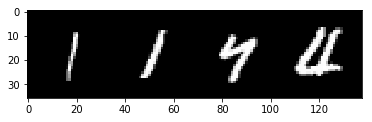

In [40]:
# get some random training images
dataiter = iter(trainloader) # define dataiter to pull next batch of images from training dataset
images, labels = dataiter.next() # get the next set of 4 images with corresponding labels

# show normalized images
img=torchvision.utils.make_grid(images)
plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
# print labels
print('Ground truth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Let's compare this to a sample of the unnormalized images:

Ground truth:      2     4     4     5


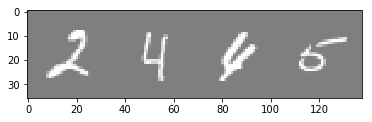

In [41]:
images, labels = dataiter.next() # get the next set of 4 images with corresponding labels

# show unnormalized images
img=torchvision.utils.make_grid(images)
img = img / 2 + 0.5     # unnormalize the images
plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
# print labels
print('Ground truth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

I'm reusing the 32x32 3-channel network from CIFAR10. In the future I'll use an appropriately sized network (1 channel 28x28), but we'll see that this still works quite well.

In [42]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum



In [43]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

These lr and momentum variables are where the interesting things happen.

All learning algorithms are solving gradient descent, and a learning rate that's too high or too low are both bad.

The learning rate weights how large a step to take during gradient descent.

Momentum is how much we're incorporating the previous direction, which is important because we can only load a subset of the data into memory.

Adam is a better optimizer?

Now we'll train the network.

This is when things start to get interesting.

Next we will loop over our data iterator, and feed the inputs to the network and optimize.



In [44]:
for epoch in range(2):  # loop over the dataset multiple times 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    for data in testloader:
        images, labels = data
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i]
            class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
    
print('Finished Training')

# When does the algorithm stop learning and start over-fitting?
# We want to determine this trend and then cut off our training before over-fitting starts.
# I updated the number of epochs from 5 to 30 (5 epochs means it sees each image 5 times)
# Tensorboard version for pytorch to show the loss over time
# or just graph the loss numbers over time to observe the trends

# Learning rate = How fast to perform gradient descent

# Check whether cats are under-represented in the training dataset, since it performed by far worst on cats.

# Put in an SVM classifier into this. - I'll need to find out how to load all the data at once rather than use the dataloader from this set.

# Try using 3 classifiers instead of 10.
# Computers, trees, something else - 10 images of each
# Test on the training dataset - it will perform perfectly
# Alternatively, find another dataset to use, so long as I'm loading it myself rather than using the dataloader

# Try on non-image data as well

[1,  2000] loss: 1.231
[1,  4000] loss: 0.221
[1,  6000] loss: 0.154
[1,  8000] loss: 0.124
[1, 10000] loss: 0.103
[1, 12000] loss: 0.100
[1, 14000] loss: 0.089
Accuracy of the network on the 10000 test images: 97 %
Accuracy of     0 : 98 %
Accuracy of     1 : 98 %
Accuracy of     2 : 97 %
Accuracy of     3 : 98 %
Accuracy of     4 : 97 %
Accuracy of     5 : 99 %
Accuracy of     6 : 96 %
Accuracy of     7 : 99 %
Accuracy of     8 : 89 %
Accuracy of     9 : 96 %
[2,  2000] loss: 0.070
[2,  4000] loss: 0.072
[2,  6000] loss: 0.072
[2,  8000] loss: 0.070
[2, 10000] loss: 0.062
[2, 12000] loss: 0.061
[2, 14000] loss: 0.057
Accuracy of the network on the 10000 test images: 98 %
Accuracy of     0 : 99 %
Accuracy of     1 : 97 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 98 %
Accuracy of     5 : 98 %
Accuracy of     6 : 97 %
Accuracy of     7 : 98 %
Accuracy of     8 : 99 %
Accuracy of     9 : 98 %
Finished Training


I've printed the averaged accuracy along with the accuracy for each digit after each epoch.

We can see that this is a much easier problem to solve than the CIFAR10 dataset. The convolution network gets 97% accuracy after a single round of training and 98% accuracy after 2 rounds. In a previous run, I got 98% accuracy after a single round of training, so we can see that this is pretty consistent between training sessions.

We can also see that it performs quite well on every digit. There aren't examples of poorly classified digits.

I've already added accuracy checks at each epoch, but now that we've trained the network, let's test it again to see how it performs re-using the more fun visual representation from before:

Ground truth:      1     4     7     7


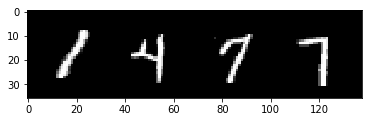

In [51]:
images, labels = dataiter.next() # get the next set of 4 images with corresponding labels

# show normalized images
img=torchvision.utils.make_grid(images)
plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
# print labels
print('Ground truth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [54]:
outputs = net(Variable(images))
print(outputs)
print(classes)

Variable containing:

Columns 0 to 7 
 -0.8202   7.2773   1.7581  -2.1656  -1.3041  -3.3534  -1.8478  -1.8616
 -4.5476   0.7416  -1.2497  -3.6737  11.4589  -3.2505  -2.5717   0.9189
 -1.8207   1.4430  -0.6530  -0.0100  -2.3903  -2.5991  -6.5629   9.1279
 -4.6457   3.0505   1.2968   4.0214  -4.5873  -2.5764  -9.6612  11.8386

Columns 8 to 9 
  4.1157  -1.1103
 -1.4588   2.8885
  0.3829   1.0914
 -1.2266   1.4965
[torch.FloatTensor of size 4x10]

('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')


The outputs are "energies" for the 10 classes.

By printing both the outputs and the classes, we can see that the network has a prediction for how likely it thinks each of the 4 images is to fall into each of the 10 classes. The higher the energy for a class, the more the network
thinks that the image is of the particular class. For instance, if we look at row 1 column 2, we can see that this is a much higher value for that row than in the other columns. Column 2 corresponds to digit '1', which is what the network has predicted for the first image.

The class with the highest energy is the one that the network is predicting. So to get the predicted class, let's get the index of the highest energy and show that prediction along with the grount truth class and images from above:

Ground truth:      1     4     7     7
Predicted:      1     4     7     7


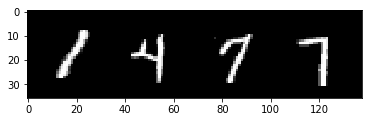

In [53]:
# show normalized images
img=torchvision.utils.make_grid(images)
plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
# print labels
print('Ground truth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

The results seem pretty good, at least for these 4 images, showing the ground truth and prediction side-by-side.

Let us look at how the network performs on the whole dataset again (which we checked after each epoch, so it should perform as well as it did after the last epoch).

In [48]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 98 %


The network clearly learned, with it ultimately performing at 98% accuracy averaged over all 10 classes.

It is performing far better than chance, which is 10%. This is the measure of the accuracy across all classes, however.

Next, let's look at the performance of predicting each class, as it is expected that not all classes trained equally well:

In [49]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 99 %
Accuracy of     1 : 97 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 98 %
Accuracy of     5 : 98 %
Accuracy of     6 : 97 %
Accuracy of     7 : 98 %
Accuracy of     8 : 99 %
Accuracy of     9 : 98 %


98% accuracy average and 97-99% within each class. Amazing for only 2 training sessions.

Now we've tried a neural network both with and without convolution layers.